In [1]:
import numpy as np
from scipy.linalg import block_diag
import numpy as np
from numpy import matmul, transpose, matrix, multiply, divide,sqrt,diag,log,pi
import matplotlib.pyplot as plt
import matplotlib.dates as dates
from numpy.linalg import inv
import pandas as pd
from numpy.linalg import eigvals, eig
from scipy.special import gammaln
import sys
from scipy.cluster.hierarchy import dendrogram, linkage
import pickle
import datetime
from numpy import zeros as zeros
from numpy import ones as ones
import string
import scipy.stats
from datetime import datetime

%matplotlib inline  

## Model Setting

In [2]:
# Trend
class dlm_trend(object):
    
    def __init__(self,order,a = None,R = 0.01, discount = 0.95):
        
        if a is None:
            a = [10]*order

        self.order = order
        
        # F
        Ftrend = np.mat(np.zeros(self.order).tolist())
        Ftrend[0] = 1
        Ftrend.shape = (order,1)
        self.F = np.matrix(Ftrend)
        
        # G 
        subG = np.identity(self.order-1)
        G = np.zeros((self.order,self.order))
        G[:order-1,1:] = subG
        np.fill_diagonal(G,1) 
        self.G = np.matrix(G)
        
        # index
        ntrend=len(Ftrend); 
        
        # prior: a, R
        self.a = np.array(a)
        self.R = np.array(R)
        self.n = ntrend
        
        self.type = 'Trend'
        self.discount = discount
            
        
# Regressor
class dlm_reg(object):
    
    def __init__(self, X ,q, a = None, R = 0.01, discount  = 0.95):
        self.q = q
        
        if a is None:
            a = [10]*self.q
        
        Freg = np.mat(np.zeros(self.q))
        Freg.shape = (self.q,1)
        self.F = Freg
        

        Greg = np.identity(self.q)
        self.G = Greg
        
        nregn=q;
        self.n = nregn
        
        # prior: a, R
        self.a = np.array(a)
        self.R = np.mat(np.diag([R]*q))
        self.X = X
        
        self.type = 'Reg'
        self.discount = discount
        
# seasonal 
class dlm_season(object):
    
    
    def __init__(self,p , rseas = [1,3,4],a = None, R = 0.01, discount = 0.95):
        
        pseas = len(rseas)
        nseas = 2*pseas
        Fseas = np.mat(np.array([1,0]*pseas))
        Fseas.shape = (2*pseas,1)
        Gseas = np.mat(np.zeros((nseas,nseas)))
        
        for j in range(pseas):
            i = j + 1 
            c = np.cos(2*np.pi*rseas[j]/p)
            s = np.sin(2*np.pi*rseas[j]/p)
            index = list(range(2*i-1,2*i+1))

            Gseas[index[0]-1:index[1],index[0]-1:index[1]] = np.mat(np.array([[c,s],[-s,c]]))


        self.G = Gseas
        self.F = Fseas
        
        nseas=2*pseas;
        self.n = nseas
        
        # prior: a, R
        if a is None:
            a = [10]*nseas
            
        self.a = np.array(a)
        R_T = np.identity(nseas)
        np.fill_diagonal(R_T,R)
        self.R = R_T
        
        self.type = 'season'
        self.discount = discount
 

In [3]:
class dlm_tvar(object):
    
    def __init__(self,ar_order,discount = 0.95,a = None , R = 1):
        
        if R is None:
            R = np.mat(np.diag([1]*ar_order))
        else:
            R = np.mat(np.diag([R]*ar_order))
        
        if a is None:
            a = [0]*ar_order
        
        self.ar_order = ar_order
        
        # F
        F_ar = np.mat(np.ones(ar_order).tolist())
        F_ar.shape = (ar_order,1)
        self.F = np.matrix(F_ar)
        
        # G 
        G_ar = np.identity(ar_order)
        
        # index
        n_ar = len(F_ar); 
        
        # prior: a, R
        self.F = F_ar
        self.G = G_ar
        self.n = n_ar
        self.R = R
        self.a = np.array(a)
        
        self.type = 'AR'
        self.discount = discount

In [4]:
class dlm_mod(object):
    
    def __init__(self, dlm_trend = None, dlm_reg = None, dlm_seas = None, dlm_tvar = None , 
                 nu = 6, S = np.power(0.15,2), delvar = 0.99):
        
        component = []
        if dlm_trend is not None:
            component.append(dlm_trend)
        if dlm_reg is not None:
            component.append(dlm_reg)
        if dlm_seas is not None:
            component.append(dlm_seas)   
        if dlm_tvar is not None:
            component.append(dlm_tvar)

        F = component[0].F
        G = component[0].G
        R = component[0].R
        a = component[0].a.tolist()
        
        index = {component[0].type: np.array(list(range(component[0].n)))}
        com_type = [component[0].type]
        dist = {component[0].type : component[0].discount}
        
        for i in range(1,len(component)):

            F = np.concatenate([F, component[i].F])
            G = np.mat(block_diag(G,component[i].G))
            R = np.mat(block_diag(R,component[i].R))

            a = a + component[i].a.tolist()
            temp_index = np.arange(max(list(index.values())[i-1]) + 1, max(list(index.values())[i-1]) + component[i].n + 1)
            index.update({component[i].type : temp_index})
            com_type.append(component[i].type)
            dist.update({component[i].type : component[i].discount})
          
        if "Reg" in com_type:
            self.X = dlm_reg.X
        else:
            self.X = None
            
        a = np.mat(a)
        a.shape = (a.shape[1],1)
        
        self.F = F
        self.G = G
        self.R = R
        self.a = a
        self.nu = nu
        self.S = S
        self.index = index
        self.type = com_type
        self.discount = dist
        self.delvar = delvar

## Model Fitting

In [60]:
class dlm_filter(object):
    
    def __init__(self, Y, mod):
              
        
        a = mod.a
        G = mod.G
        S = mod.S
        R = mod.R
        F = mod.F
        nu = mod.nu

        X = mod.X

        delvar = mod.delvar
        
        n = len([j for i in list(mod.index.values()) for j in i])
        T = len(Y)

        # storage arrays for filtering summaries: 
        sm=zeros([n,T]);
        sa=zeros([n,T]); 
        sC=zeros([n,n,T]); 
        sR=zeros([n,n,T]); 
        sf=zeros([1,T]); 
        se=zeros([1,T]);
        sQ=zeros([1,T]); 
        sS=zeros([1,T]); 
        snu=zeros([1,T]); 
        mlik=zeros([1,T]); 

        if 'AR' in list(mod.index.keys()):
            # AR order
            ar_order = len(mod.F)


        print('Start filtering.......',file = sys.stderr)
        for t in range(T):
            if t>0:

                if 'Trend' in list(mod.index.keys()):
                    itrend = (mod.index['Trend'])
                    deltrend = mod.discount['Trend']
                    R[itrend,itrend]=R[itrend,itrend]/deltrend; 

                if 'season' in list(mod.index.keys()):
                    iseas = (mod.index['season'])
                    delseas = mod.discount['season']
                    R[iseas,iseas]=R[iseas,iseas]/delseas; 


                if 'Reg' in list(mod.index.keys()):
                    iregn = (mod.index['Reg'])
                    delregn = mod.discount['Reg']
                    R[iregn,iregn]=R[iregn,iregn]/delregn; 

                if 'AR' in list(mod.index.keys()):
                    iar = (mod.index['AR'])
                    delar = mod.discount['AR']
                    R[iar,iar]=R[iar,iar]/delar; 

                a = G@m; 
                R = G@C@transpose(G); 

            #first_step += 1

            if 'Reg' in list(mod.index.keys()):
                iregn = (mod.index['Reg'])

                Fregn = np.array(X[t]).reshape([len(iregn),1])
                F[iregn]=Fregn

            if 'AR' in list(mod.index.keys()):
                iar = (mod.index['AR'])
                if t < ar_order:
                    Far = np.append(np.array([0]*(ar_order - t)),Y[range(t)]).reshape([ar_order,1])

                else:
                    Far=(Y[range((t-1),(t-ar_order-1),-1)]).reshape([ar_order,1]);
                F[iar]=Far



            A = R@F; 
            Q = np.array(transpose(F) @ A + S)
            A = A/Q
            f = transpose(F)@a

            # update

            y = Y[t];  
            e = y - f 
            rQ=sqrt(Q);

            mlik[:,t] = scipy.stats.t.pdf(e/rQ,nu)/rQ
            r=np.array((nu+e**2/Q)/(nu+1));
            m = a + A * e;

            C = np.multiply(r,(R- np.multiply(A@transpose(A) , Q)))
            nu = delvar * nu + 1; 
            S=r*S; 

            # adjust shape

            sm[:,t] = transpose(m); 
            sC[:,:,t]=C; 
            sa[:,t] = transpose(a); 
            sR[:,:,t]=R; 
            sf[:,t]=f; 
            sQ[:,t]=Q; 
            sS[:,t]=S; 
            snu[:,t]=nu;
            se[:,t] = e
            
        MSE = np.sum(se**2)

            
        self.sm = sm
        self.sC = sC
        self.sa = sa
        self.sR = sR
        self.sf = sf
        self.se = se
        self.sQ = sQ
        self.sS = sS
        self.snu = snu
        self.smlik = mlik
        self.MSE = MSE

## Trend Seasonal Reg: salesindex

In [21]:
import scipy.io as spio
mat = spio.loadmat('/Users/mueric35/Desktop/Course/STA642/Code+data/Data/salesindex.mat', squeeze_me=True)
X = mat['index']
Y = mat['sales']

In [22]:
mod_trend = dlm_trend(1, a = [9.5] ,R = 0.09,discount=0.9)
mod_reg = dlm_reg(X,q = 1,a=[-0.7],R=0.01,discount=0.95)
mod_seas = dlm_season(12,[1,3,4],R = 0.0067, a = [0.691 ,1.159 ,0.283 ,-0.050 ,-0.217 ,0.144],discount=0.95)
mod = dlm_mod(dlm_trend = mod_trend,dlm_reg = mod_reg, dlm_seas=mod_seas,nu=6,S=0.0225)

Start filtering.......


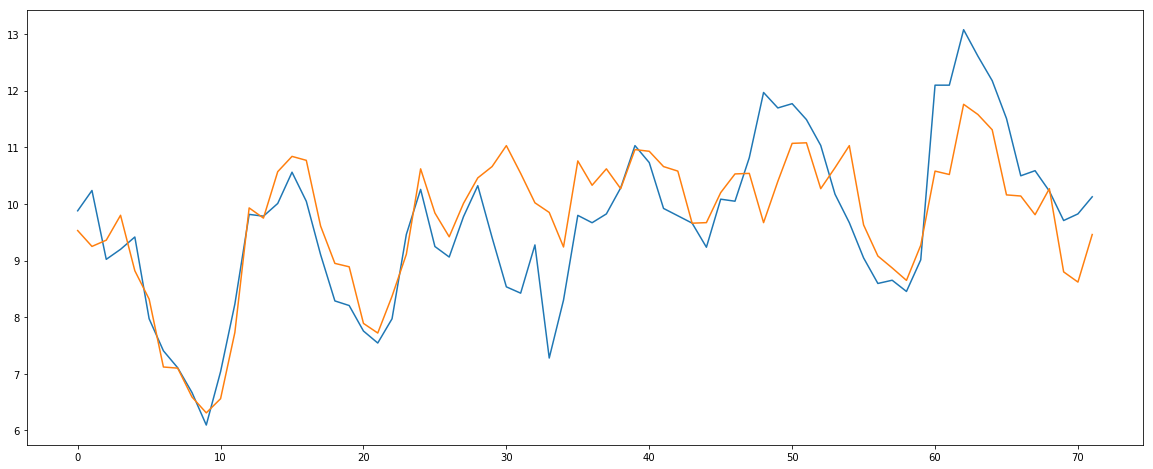

In [23]:
plt.figure(figsize=(20,8))
temp = dlm_filter(Y,mod)
plt.plot(transpose(temp.sf));
plt.plot(transpose(Y));

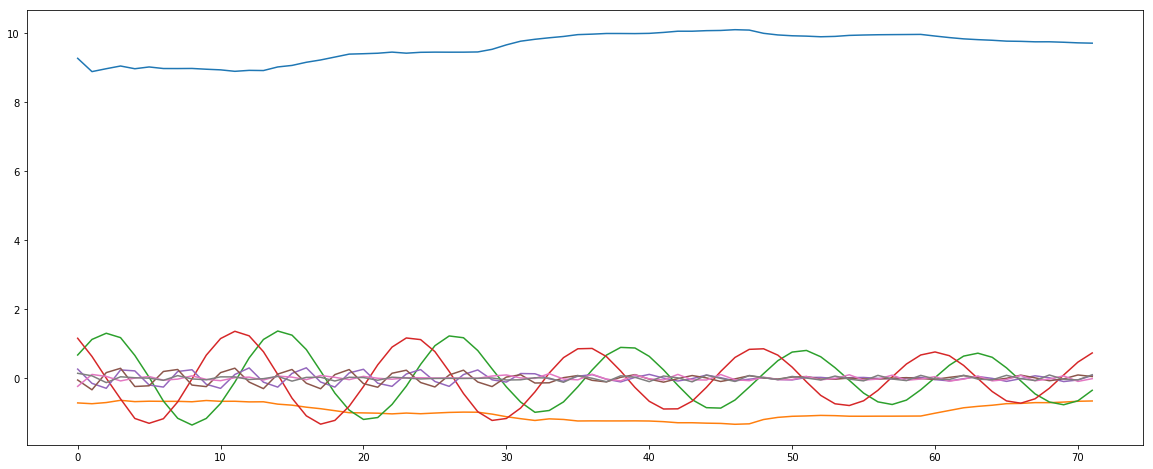

In [24]:
plt.figure(figsize=(20,8))
plt.plot(transpose(temp.sm));

## USmacrodata example 

In [ ]:
data = pd.read_excel('/Users/mueric35/Desktop/Course/STA642/Code+data/Data/USmacrodata1960-2014.xlsx')

In [ ]:
Y = np.append([0],np.diff(data.iloc[:,2]))
Y = Y - np.mean(Y)
mod = dlm_mod(dlm_tvar(ar_order=8,discount=0.95))


In [ ]:
plt.figure(figsize=(20,8))
temp = dlm_filter(Y,mod)
plt.plot(transpose(temp.sf));
plt.plot(transpose(Y));

In [ ]:
plt.figure(figsize=(20,8))
plt.plot(transpose(temp.sm));

## Read Vix

### Read GT

In [48]:
df = pd.read_csv('/Users/mueric35/Desktop/Sentiment-and-Marktet-Analysis/GTdata/df_all_daily_raw.csv', index_col= 0)
df['Date'] = list(df.index)
df['Date'] = df['Date'].apply(lambda x : datetime.strptime(x,'%Y-%m-%d').date())


### Read VIX

In [49]:
vix_data = pd.read_csv('/Users/mueric35/Desktop/Sentiment-and-Marktet-Analysis/GTdata/VIX.csv')
vix_data = vix_data[['Date','Close']]
# turn str into date 
vix_data['Date'] = vix_data['Date'].apply(lambda x : datetime.strptime(x,'%m/%d/%y').date())
# select time frame
vix_model_data = vix_data[(vix_data['Date'] > datetime(2017,1,1).date() )&(vix_data['Date'] < datetime(2018,1,21).date() ) ]
data = vix_model_data.merge(df,on = 'Date')


In [50]:
# s_p
#df = pd.read_csv('/Users/mueric35/Desktop/Sentiment-and-Marktet-Analysis/s_p.csv').iloc[:,1:]

In [51]:
Y = np.array(data['Close'])
Y = np.log(Y)
Y = np.append(np.array([0]),np.diff(Y))
Date = data['Date']

### Constructing model - Tuning

In [76]:
dis_ar = np.arange(0.9,1,0.005)
delvar = np.arange(0.9,1,0.005)
R = np.arange(0.1,0.4,0.05)
mse = []

index = []
for d_ar in dis_ar:
    for d_var in delvar:
        for r in R:
            mod_ar = dlm_tvar(12,discount = d_ar, a = [-0.05 , -0.05 , -0.05 , -0.1, -0.1,
                0.26, -0.49,  0.4,  0.05, -0.33, 0.30,  0.17 ],R = r)
            mod = dlm_mod(dlm_reg=None,dlm_seas=None,dlm_trend=None,dlm_tvar=mod_ar,delvar = d_var)
            mse.append(dlm_filter(Y,mod).MSE)
            index.append(str(d_ar) + ' ' + str(d_var) + ' ' + str(r))


Start filtering.......
Start filtering.......
Start filtering.......
Start filtering.......
Start filtering.......
Start filtering.......
Start filtering.......
Start filtering.......
Start filtering.......
Start filtering.......
Start filtering.......
Start filtering.......
Start filtering.......
Start filtering.......
Start filtering.......
Start filtering.......
Start filtering.......
Start filtering.......
Start filtering.......
Start filtering.......
Start filtering.......
Start filtering.......
Start filtering.......
Start filtering.......
Start filtering.......
Start filtering.......
Start filtering.......
Start filtering.......
Start filtering.......
Start filtering.......
Start filtering.......
Start filtering.......
Start filtering.......
Start filtering.......
Start filtering.......
Start filtering.......
Start filtering.......
Start filtering.......
Start filtering.......
Start filtering.......
Start filtering.......
Start filtering.......
Start filtering.......
Start filte

Start filtering.......
Start filtering.......
Start filtering.......
Start filtering.......
Start filtering.......
Start filtering.......
Start filtering.......
Start filtering.......
Start filtering.......
Start filtering.......
Start filtering.......
Start filtering.......
Start filtering.......
Start filtering.......
Start filtering.......
Start filtering.......
Start filtering.......
Start filtering.......
Start filtering.......
Start filtering.......
Start filtering.......
Start filtering.......
Start filtering.......
Start filtering.......
Start filtering.......
Start filtering.......
Start filtering.......
Start filtering.......
Start filtering.......
Start filtering.......
Start filtering.......
Start filtering.......
Start filtering.......
Start filtering.......
Start filtering.......
Start filtering.......
Start filtering.......
Start filtering.......
Start filtering.......
Start filtering.......
Start filtering.......
Start filtering.......
Start filtering.......
Start filte

Start filtering.......
Start filtering.......
Start filtering.......
Start filtering.......
Start filtering.......
Start filtering.......
Start filtering.......
Start filtering.......
Start filtering.......
Start filtering.......
Start filtering.......
Start filtering.......
Start filtering.......
Start filtering.......
Start filtering.......
Start filtering.......
Start filtering.......
Start filtering.......
Start filtering.......
Start filtering.......
Start filtering.......
Start filtering.......
Start filtering.......
Start filtering.......
Start filtering.......
Start filtering.......
Start filtering.......
Start filtering.......
Start filtering.......
Start filtering.......
Start filtering.......
Start filtering.......
Start filtering.......
Start filtering.......
Start filtering.......
Start filtering.......
Start filtering.......
Start filtering.......
Start filtering.......
Start filtering.......
Start filtering.......
Start filtering.......
Start filtering.......
Start filte

Start filtering.......
Start filtering.......
Start filtering.......
Start filtering.......
Start filtering.......
Start filtering.......
Start filtering.......
Start filtering.......
Start filtering.......
Start filtering.......
Start filtering.......
Start filtering.......
Start filtering.......
Start filtering.......
Start filtering.......
Start filtering.......
Start filtering.......
Start filtering.......
Start filtering.......
Start filtering.......
Start filtering.......
Start filtering.......
Start filtering.......
Start filtering.......
Start filtering.......
Start filtering.......
Start filtering.......
Start filtering.......
Start filtering.......
Start filtering.......
Start filtering.......
Start filtering.......
Start filtering.......
Start filtering.......
Start filtering.......
Start filtering.......
Start filtering.......
Start filtering.......
Start filtering.......
Start filtering.......
Start filtering.......
Start filtering.......
Start filtering.......
Start filte

Start filtering.......
Start filtering.......
Start filtering.......
Start filtering.......
Start filtering.......
Start filtering.......
Start filtering.......
Start filtering.......
Start filtering.......
Start filtering.......
Start filtering.......
Start filtering.......
Start filtering.......
Start filtering.......
Start filtering.......
Start filtering.......
Start filtering.......
Start filtering.......
Start filtering.......
Start filtering.......
Start filtering.......
Start filtering.......
Start filtering.......
Start filtering.......
Start filtering.......
Start filtering.......
Start filtering.......
Start filtering.......
Start filtering.......
Start filtering.......
Start filtering.......
Start filtering.......
Start filtering.......
Start filtering.......
Start filtering.......
Start filtering.......
Start filtering.......
Start filtering.......
Start filtering.......
Start filtering.......
Start filtering.......
Start filtering.......
Start filtering.......
Start filte

Start filtering.......
Start filtering.......
Start filtering.......
Start filtering.......
Start filtering.......
Start filtering.......
Start filtering.......
Start filtering.......
Start filtering.......
Start filtering.......
Start filtering.......
Start filtering.......
Start filtering.......
Start filtering.......
Start filtering.......
Start filtering.......
Start filtering.......
Start filtering.......
Start filtering.......
Start filtering.......
Start filtering.......
Start filtering.......
Start filtering.......
Start filtering.......
Start filtering.......
Start filtering.......
Start filtering.......
Start filtering.......
Start filtering.......
Start filtering.......
Start filtering.......
Start filtering.......
Start filtering.......
Start filtering.......
Start filtering.......
Start filtering.......
Start filtering.......
Start filtering.......
Start filtering.......
Start filtering.......
Start filtering.......
Start filtering.......
Start filtering.......
Start filte

Start filtering.......
Start filtering.......
Start filtering.......
Start filtering.......
Start filtering.......
Start filtering.......
Start filtering.......
Start filtering.......
Start filtering.......
Start filtering.......
Start filtering.......
Start filtering.......
Start filtering.......
Start filtering.......
Start filtering.......
Start filtering.......
Start filtering.......
Start filtering.......
Start filtering.......
Start filtering.......
Start filtering.......
Start filtering.......
Start filtering.......
Start filtering.......
Start filtering.......
Start filtering.......
Start filtering.......
Start filtering.......
Start filtering.......
Start filtering.......
Start filtering.......
Start filtering.......
Start filtering.......
Start filtering.......
Start filtering.......
Start filtering.......
Start filtering.......
Start filtering.......
Start filtering.......
Start filtering.......
Start filtering.......
Start filtering.......
Start filtering.......
Start filte

Start filtering.......
Start filtering.......
Start filtering.......
Start filtering.......
Start filtering.......
Start filtering.......
Start filtering.......
Start filtering.......
Start filtering.......
Start filtering.......
Start filtering.......
Start filtering.......
Start filtering.......
Start filtering.......
Start filtering.......
Start filtering.......
Start filtering.......
Start filtering.......
Start filtering.......
Start filtering.......
Start filtering.......
Start filtering.......
Start filtering.......
Start filtering.......
Start filtering.......
Start filtering.......
Start filtering.......
Start filtering.......
Start filtering.......
Start filtering.......
Start filtering.......
Start filtering.......
Start filtering.......
Start filtering.......
Start filtering.......
Start filtering.......
Start filtering.......
Start filtering.......
Start filtering.......
Start filtering.......
Start filtering.......
Start filtering.......
Start filtering.......
Start filte

In [77]:
index[mse.index(min(mse))]

'0.9 0.9 0.4'

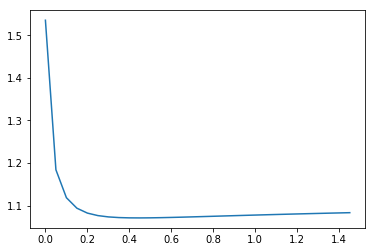

In [68]:
plt.plot(R,mse)

In [79]:
mod_ar = dlm_tvar(12,discount=0.9,a = [-0.05 , -0.05 , -0.05 , -0.1, -0.1,
        0.26, -0.49,  0.4,  0.05, -0.33, 0.30,  0.17 ],R = 0.4)
mod = dlm_mod(dlm_reg=None,dlm_seas=None,dlm_trend=None,dlm_tvar=mod_ar,delvar=0.9)

Start filtering.......


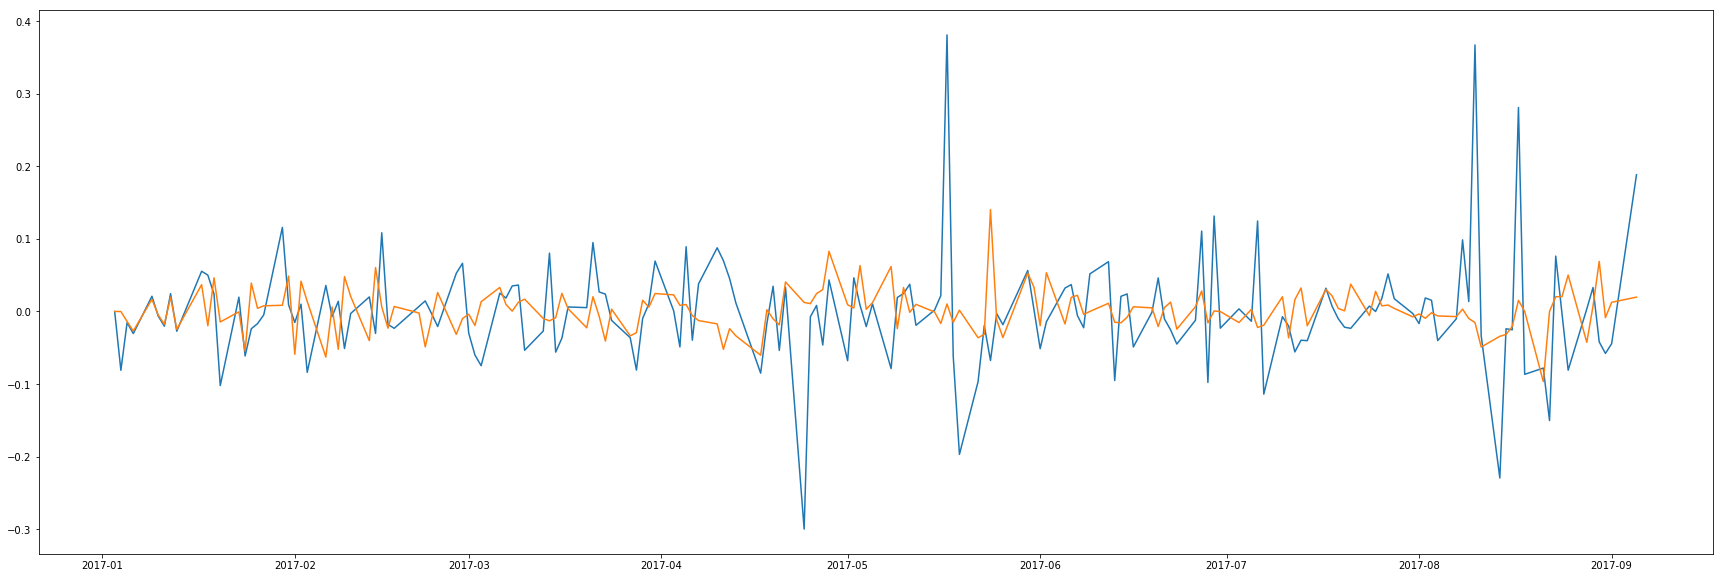

In [80]:
plt.figure(figsize=(30,10))
temp = filter(Y,mod)
plt.plot(Date,transpose(Y));
plt.plot(Date,transpose(temp.sf));


In [81]:
def plot_1_step(dlm_object,p):
    sq=scipy.stats.t.ppf(p,dlm_object.snu);

    h= np.multiply(sqrt(dlm_object.sQ),sq)

    higher = dlm_object.sf + h
    lower = dlm_object.sf - h
    plt.figure(figsize=(30,10))
    plt.fill_between(range(higher.shape[1]),higher.flatten().tolist(),lower.flatten().tolist(),
                     color='lightgray', alpha=0.5);
    plt.plot(transpose(dlm_object.sf), color = 'blue')
    plt.plot(transpose(Y),  'r+', markersize=20)
    plt.title('90% prediction intervals and 1-step forecasts',fontsize = 20)
    plt.tick_params(labelsize=20)

    high_sq = sq
    low_sq = -sq
    plt.figure(figsize=(30,10))
    plt.fill_between(range(higher.shape[1]),high_sq.flatten().tolist(),low_sq.flatten().tolist(),
                     color='lightgray', alpha=0.5);
    std = np.multiply(Y - dlm_object.sf, np.sqrt(1/sq))
    plt.plot(transpose(std),'r+',markersize=20);
    plt.title('90% prediction intervals and standardized 1-step errors',fontsize = 20);
    plt.tick_params(labelsize=20)



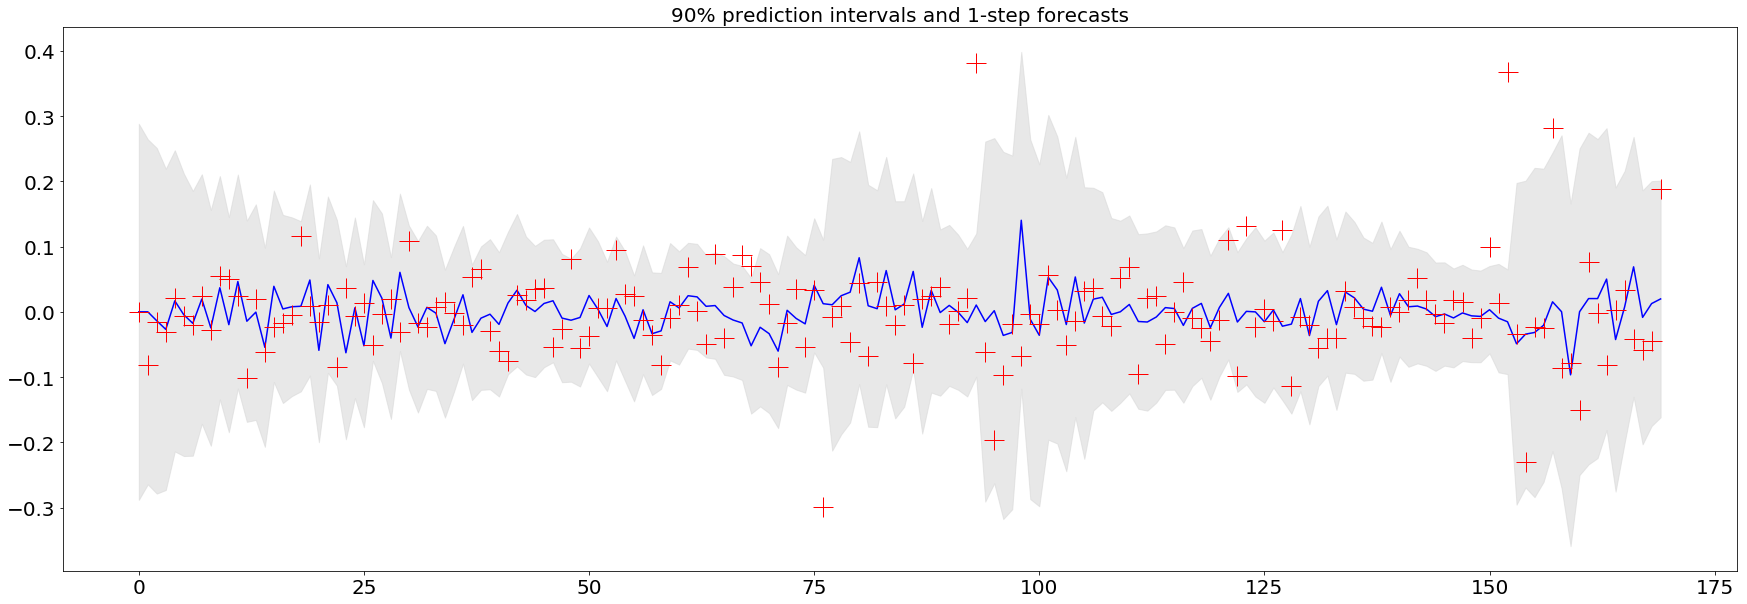

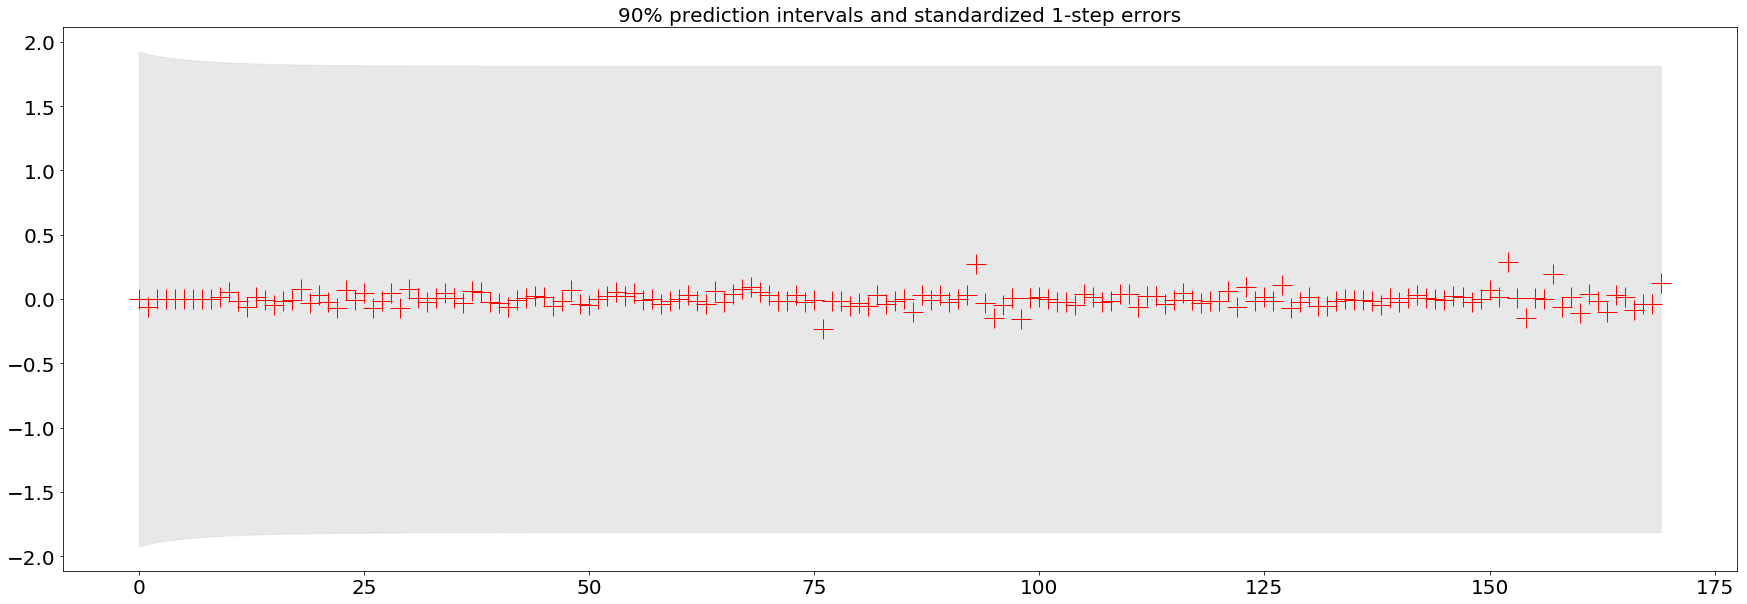

In [82]:
plot_1_step(temp,0.95)

54.419389193560264

In [25]:
sm = temp.sm
sC = temp.sC
sR = temp.sR
sa = temp.sa
sS = temp.sS
snu = temp.snu


In [27]:
Sm = sm.copy(); 
SC = sC.copy(); 
SR = sR.copy();  
Sa = sa.copy(); 
SS = sS.copy(); 
Snu = snu.copy(); 
T = 72
G = mod.G
# then perform backward (Viterbi style) updating - overwriting
#  online posterior summaries at each time point with full posteriors: 
C=sC[:,:,T-1]; 
St=sS[:,T-1];
nu=snu[:,T-1]; 
delvar = 0.99
for t in list(range(0,T-1))[::-1]:    

    B  = sC[:,:,t]@transpose(G)@inv(sR[:,:,t+1]);              
    sm[:,t] = sm[:,t]+B@(sm[:,t+1]-sa[:,t+1]);        
    C  = sC[:,:,t]+B@(C-sR[:,:,t+1])@transpose(B);  
    St = (1-delvar)/sS[:,t] + delvar/St; 
    St=1/St; 
    SS[:,t]=St; 
    nu  = (1-delvar)*snu[:,t]+delvar*nu; 
    Snu[:,t]=nu; 
    sC[:,:,t] = np.multiply(C,St)/sS[:,t]

In [ ]:
Sm = sm.copy(); 
SC = sC.copy(); 
SR = sR.copy();  
Sa = sa.copy(); 
SS = sS.copy(); 
Snu = snu.copy(); 
# then perform backward (Viterbi style) updating - overwriting
#  online posterior summaries at each time point with full posteriors: 
C=sC[:,:,T-1]; 
St=sS[:,T-1];
nu=snu[:,T-1]; 
delvar = 0.99

In [ ]:
T = 72
C=sC[:,:,T-1]; 
St=sS[:,T-1];
nu=snu[:,T-1]; 
delvar = 0.99
t = 70
print(sm[:,t] , B@(sm[:,t+1]-sa[:,t+1]))

sm[:,t] = sm[:,t] + B@(sm[:,t+1]-sa[:,t+1])
C  = sC[:,:,t] + B@(C-sR[:,:,t+1])@transpose(B);  
St = (1-delvar)/sS[:,t] + delvar/St; 
St=1/St; 
SS[:,t]=St; 
nu  = (1-delvar)*snu[:,t]+delvar*nu; 
Snu[:,t]=nu; 
sC[:,:,t] = np.multiply(C,St)/sS[:,t]

In [ ]:
t = 69
B  = sC[:,:,t]@transpose(G)@inv(sR[:,:,t+1]);
#print(sm[:,t])
#print(B@(sm[:,t+1]-sa[:,t+1]) )
print(sm[:,t] , B@(sm[:,t+1]-sa[:,t+1]))

sm[:,t] = sm[:,t]+B@(sm[:,t+1]-sa[:,t+1]);  
C  = sC[:,:,t]+B@(C-sR[:,:,t+1])@transpose(B);  
St = (1-delvar)/sS[:,t] + delvar/St; 
St=1/St; 
SS[:,t]=St; 
nu  = (1-delvar)*snu[:,t]+delvar*nu; 
Snu[:,t]=nu; 
sC[:,:,t] = np.multiply(C,St)/sS[:,t]

In [ ]:
t = 68
B  = sC[:,:,t]@transpose(G)@inv(sR[:,:,t+1]);
#print(sm[:,t])
#print(B@(sm[:,t+1]-sa[:,t+1]) )
print(sm[:,t] , B@(sm[:,t+1]-sa[:,t+1]))

sm[:,t] = sm[:,t]+B@(sm[:,t+1]-sa[:,t+1]);  
C  = sC[:,:,t]+B@(C-sR[:,:,t+1])@transpose(B);  
St = (1-delvar)/sS[:,t] + delvar/St; 
St=1/St; 
SS[:,t]=St; 
nu  = (1-delvar)*snu[:,t]+delvar*nu; 
Snu[:,t]=nu; 
sC[:,:,t] = np.multiply(C,St)/sS[:,t]


In [ ]:
T

In [ ]:
plt.plot(transpose(sf))
plt.plot(transpose(Y))